<a href="https://colab.research.google.com/github/pkrosoff/wine_machine_learning/blob/kelly_branch/wine_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.1'
# spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done


In [2]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("wine_hashing").getOrCreate()

In [3]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import regexp_replace, col


In [4]:
# from pyspark import SparkFiles
# path ="/content/drive/MyDrive/winemag-data_first150k.csv"
# spark.sparkContext.addFile(path)
# df = spark.read.csv(SparkFiles.get("winemag-data_first150k.csv"), sep=",", header=True)

path = "/content/drive/MyDrive/winemag-data_first150k.csv"
df = pd.read_csv(path)

In [5]:
df


,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...,...,...,...
150925,150925,Italy,Many people feel Fiano represents southern Ita...,NaN,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio
150926,150926,France,"Offers an intriguing nose with ginger, lime an...",Cuvée Prestige,91,27.0,Champagne,Champagne,NaN,Champagne Blend,H.Germain
150927,150927,Italy,This classic example comes from a cru vineyard...,Terre di Dora,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Terredora
150928,150928,France,"A perfect salmon shade, with scents of peaches...",Grand Brut Rosé,90,52.0,Champagne,Champagne,NaN,Champagne Blend,Gosset


In [6]:
# Examine the schema 
print("# of NaN in every column\n", df.isnull().sum(axis = 0))

# of NaN in every column
 Unnamed: 0         0
country            5
description        0
designation    45735
points             0
price          13695
province           5
region_1       25060
region_2       89977
variety            0
winery             0
dtype: int64


In [7]:
# select only id, country, price, and NOT point
df_2 = df[['description', 'price']]


In [8]:
df_2
df_2['price'].unique()
# df_2['points'].unique()

array([ 235.,  110.,   90.,   65.,   66.,   73.,   60.,   80.,   48.,
        185.,  325.,  290.,   75.,   24.,   79.,  220.,   45.,   57.,
         62.,  105.,   15.,   37.,   nan,   22.,   42.,  135.,   29.,
         23.,   17.,   26.,   55.,   39.,   69.,   30.,   50.,   40.,
        100.,   68.,   28.,   18.,   25.,   36.,   38.,   85.,   19.,
         54.,   59.,   10.,   12.,   13.,   14.,   20.,  125.,    7.,
         49.,   93.,   32.,   16.,   21.,   44.,   35.,   61.,   34.,
         11.,   58.,  120.,   41.,  200.,   43.,    9.,   56.,   46.,
         92.,   94.,   27.,   95.,   33.,   70.,  155.,   63.,  130.,
        115.,   31.,   98.,   52.,   64.,   91.,  111.,   88.,   74.,
         77.,   87.,  113.,  140.,  500.,   51.,  150.,  240.,   72.,
        103.,    8.,  136.,  141.,  102.,   47.,   53.,   96.,   78.,
        149.,  138.,  117.,    4.,   99.,  848.,  450.,  330.,  175.,
         89.,   82.,   71.,  137.,  145.,  698.,  160.,  770.,  118.,
        238.,  202.,

In [9]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   description  150930 non-null  object 
 1   price        137235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.3+ MB


In [10]:
print("# of NaN in every column\n", df_2.isnull().sum(axis = 0))

# of NaN in every column
 description        0
price          13695
dtype: int64


In [11]:
# drop NaN
df_2 = df_2.dropna()
df_2

,description,price
0,This tremendous 100% varietal wine hails from ...,235.0
1,"Ripe aromas of fig, blackberry and cassis are ...",110.0
2,Mac Watson honors the memory of a wine once ma...,90.0
3,"This spent 20 months in 30% new French oak, an...",65.0
4,"This is the top wine from La Bégude, named aft...",66.0
...,...,...
150925,Many people feel Fiano represents southern Ita...,20.0
150926,"Offers an intriguing nose with ginger, lime an...",27.0
150927,This classic example comes from a cru vineyard...,20.0
150928,"A perfect salmon shade, with scents of peaches...",52.0


In [12]:
print("# of NaN in every column\n", df_2.isnull().sum(axis = 0))

# of NaN in every column
 description    0
price          0
dtype: int64


In [13]:
df_3 = df_2.assign(description_length = df_2['description'].apply(len))
df_3.info()
df_3.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137235 entries, 0 to 150929
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   description         137235 non-null  object 
 1   price               137235 non-null  float64
 2   description_length  137235 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ MB


,description,price,description_length
0,This tremendous 100% varietal wine hails from ...,235.0,355
1,"Ripe aromas of fig, blackberry and cassis are ...",110.0,318
2,Mac Watson honors the memory of a wine once ma...,90.0,280
3,"This spent 20 months in 30% new French oak, an...",65.0,386
4,"This is the top wine from La Bégude, named aft...",66.0,376


In [14]:
# describe the price
df_3['price'].describe()

# nunuique for price
df_3['price'].nunique()

357

In [15]:
# Bin the prices so the range of prices is more manageable for the model

# BINS NUMBER: 1, Returns 74% Accuracy

def price_bins(price):
    if price < 35:
        return 1
    elif price >= 35 and price < 70:
        return 2 
    elif price >= 70 and price < 105:
        return 3 
    elif price >= 105 and price < 140:
        return 5 
    elif price >= 140 and price < 175:
        return 6
    elif price >= 175 and price < 210:
        return 7
    elif price >= 210 and price < 245:
        return 8
    elif price >= 245 and price < 280:
        return 9
    elif price >= 280 and price < 315:
        return 10
    elif price >= 315 and price < 350:
        return 11
    elif price >= 350 and price < 385:
        return 12
    elif price >= 385 and price < 420:
        return 13
    elif price >= 420 and price < 455:
        return 14
    elif price >= 455 and price < 490:
        return 15
    elif price >= 490 and price < 525:
        return 16
    elif price >= 525 and price < 560:
        return 17
    elif price >= 560 and price < 595:
        return 18
    elif price >= 595 and price < 630:
        return 19
    elif price >= 630 and price < 665:
        return 20
    elif price >= 665 and price < 700:
        return 21
    else:
        return 22

# # #Applying transform method and assigning result to new column "points_simplified"
df_3 = df_3.assign(price_grouped = df_3['price'].apply(price_bins))
df_3.head()



,description,price,description_length,price_grouped
0,This tremendous 100% varietal wine hails from ...,235.0,355,8
1,"Ripe aromas of fig, blackberry and cassis are ...",110.0,318,5
2,Mac Watson honors the memory of a wine once ma...,90.0,280,3
3,"This spent 20 months in 30% new French oak, an...",65.0,386,2
4,"This is the top wine from La Bégude, named aft...",66.0,376,2


In [16]:
# # ALTERNATIVE BINS MODEL NUMBER: 2, Returns 83% Accuracy

# def price_bins_2(price):
#     if price < 50:
#         return 1
#     elif price >= 50 and price < 100:
#         return 2
#     elif price >= 100 and price < 150:
#         return 3
#     elif price >= 150 and price < 200:
#         return 4
#     elif price >= 200 and price < 250:
#         return 5
#     elif price >= 250 and price < 300:
#         return 6
#     elif price >= 300 and price < 350:
#         return 7
#     elif price >= 350 and price < 400:
#         return 8
#     elif price >= 400 and price < 450:
#         return 9
#     elif price >= 450 and price < 500:
#         return 10
#     elif price >= 500 and price < 550:
#         return 11
#     elif price >= 550 and price < 600:
#         return 12
#     elif price >= 600 and price < 650:
#         return 13
#     elif price >= 650 and price < 700:
#         return 14
#     else:
#         return 15

# #Applying transform method and assigning result to new column "points_simplified"
# df_3 = df_3.assign(price_grouped = df_3['price'].apply(price_bins_2))
# df_3.head()

In [17]:
# # ALTERNATIVE BINS MODEL NUMBER: 3, Returns 92% Accuracy

# def price_bins_3(price):
#     if price < 75:
#         return 1
#     elif price >= 75 and price < 150:
#         return 2
#     elif price >= 150 and price < 225:
#         return 3
#     elif price >= 225 and price < 300:
#         return 4
#     elif price >= 300 and price < 375:
#         return 5
#     elif price >= 375 and price < 450:
#         return 6
#     elif price >= 450 and price < 525:
#         return 7
#     elif price >= 525 and price < 600:
#         return 8
#     elif price >= 600 and price < 675:
#         return 9
#     else:
#         return 10

# #Applying transform method and assigning result to new column "points_simplified"
# df_3 = df_3.assign(price_grouped = df_3['price'].apply(price_bins_3))
# df_3.head()

In [18]:
# # ALTERNATIVE BINS MODEL NUMBER: 4, Returns 96% Accuracy

# def price_bins_4(price):
#     if price < 100:
#         return 1
#     elif price >= 100 and price < 200:
#         return 2
#     elif price >= 200 and price < 300:
#         return 3
#     elif price >= 300 and price < 400:
#         return 4
#     elif price >= 400 and price < 500:
#         return 5
#     elif price >= 500 and price < 600:
#         return 6
#     elif price >= 600 and price < 700:
#         return 7
#     else:
#         return 8

# # #Applying transform method and assigning result to new column "points_simplified"
# df_3 = df_3.assign(price_grouped = df_3['price'].apply(price_bins_4))
# df_3.head()

In [19]:
# # ALTERNATIVE BINS MODEL NUMBER: 5, Returns 50% Accuracy

# USE for histogram, IT shows the distribution is mainly consisting of wines less than $100

# def price_bins_5(price):
#     if price < 10:
#         return 1
#     elif price >= 10 and price < 20:
#         return 2
#     elif price >= 20 and price < 30:
#         return 3
#     elif price >= 30 and price < 40:
#         return 4
#     elif price >= 40 and price < 50:
#         return 5
#     elif price >= 50 and price < 60:
#         return 6
#     elif price >= 60 and price < 70:
#         return 7
#     elif price >= 70 and price < 80:
#         return 8
#     elif price >= 80 and price < 90:
#         return 9
#     elif price >= 90 and price < 100:
#         return 10
#     else:
#         return 11

# # #Applying transform method and assigning result to new column "points_simplified"
# df_3 = df_3.assign(price_grouped = df_3['price'].apply(price_bins_5))
# df_3.head()

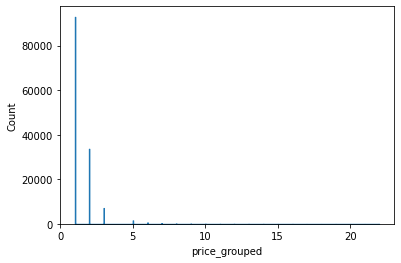

In [20]:
# Histogram
bins = df_3['price_grouped'].nunique()


sns.histplot(data=df_3, x="price_grouped", element="step")


Converting the Pandas Dataframe to a Pyspark Dataframe 


In [21]:

# Pandas to Spark
wine_DF = spark.createDataFrame(df_3)

wine_DF.show()

+--------------------+-----+------------------+-------------+
|         description|price|description_length|price_grouped|
+--------------------+-----+------------------+-------------+
|This tremendous 1...|235.0|               355|            8|
|Ripe aromas of fi...|110.0|               318|            5|
|Mac Watson honors...| 90.0|               280|            3|
|This spent 20 mon...| 65.0|               386|            2|
|This is the top w...| 66.0|               376|            2|
|Deep, dense and p...| 73.0|               315|            3|
|Slightly gritty b...| 65.0|               319|            2|
|Lush cedary black...|110.0|               357|            5|
|This re-named vin...| 65.0|               298|            2|
|The producer sour...| 60.0|               307|            2|
|Elegance, complex...| 80.0|               374|            3|
|From 18-year-old ...| 48.0|               260|            2|
|A standout even i...| 48.0|               289|            2|
|This wi

In [22]:
# find the number of missing values per column
from pyspark.sql.functions import isnan, when, count, col, isnull

wine_DF.select([count(when(isnull(j), j)).alias(j) for j in wine_DF.columns]).show()


+-----------+-----+------------------+-------------+
|description|price|description_length|price_grouped|
+-----------+-----+------------------+-------------+
|          0|    0|                 0|            0|
+-----------+-----+------------------+-------------+



Feeding the NLP model to catagorize the wines into price points


In [23]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
# Create all the features to the data set
wine_prices = StringIndexer(inputCol='price_grouped',outputCol='label')
tokenizer = Tokenizer(inputCol="description", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
hashingTF = HashingTF(inputCol="stop_tokens", outputCol='hash_token')
idf = IDF(inputCol='hash_token', outputCol='idf_token')



In [24]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

# Create feature vectors
clean_up = VectorAssembler(inputCols=['idf_token', 'description_length'], outputCol='features')

In [25]:
# Create a and run a data processing Pipeline
from pyspark.ml import Pipeline
data_prep_pipeline = Pipeline(stages=[wine_prices, tokenizer, stopremove, hashingTF, idf, clean_up])

In [26]:
# fit n transform pipeline
cleaner = data_prep_pipeline.fit(wine_DF)
cleaned = cleaner.transform(wine_DF)




In [27]:
# Show label and resulting features
cleaned.select(['label', 'features']).show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  6.0|(262145,[2701,160...|
|  3.0|(262145,[11481,33...|
|  2.0|(262145,[10077,26...|
|  1.0|(262145,[1546,423...|
|  1.0|(262145,[1546,171...|
|  2.0|(262145,[8408,181...|
|  1.0|(262145,[5561,196...|
|  3.0|(262145,[4235,315...|
|  1.0|(262145,[2306,316...|
|  1.0|(262145,[3354,415...|
|  2.0|(262145,[3848,939...|
|  1.0|(262145,[3456,215...|
|  1.0|(262145,[4176,894...|
|  2.0|(262145,[8297,120...|
|  5.0|(262145,[5847,160...|
|  2.0|(262145,[1546,439...|
| 10.0|(262145,[18911,55...|
|  2.0|(262145,[2701,104...|
|  8.0|(262145,[1546,544...|
|  2.0|(262145,[3572,190...|
+-----+--------------------+
only showing top 20 rows



In [28]:

from pyspark.ml.classification import NaiveBayes

# Break data down into a training set and a testing set
training, testing = cleaned.randomSplit([0.7, 0.3])

# Create a Naive Bayes model and fit training data
nb = NaiveBayes()
predictor = nb.fit(training)


In [29]:

# Tranform the model with the testing data
test_results = predictor.transform(testing)
test_results.show(5)

+--------------------+-----+------------------+-------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|         description|price|description_length|price_grouped|label|          token_text|         stop_tokens|          hash_token|           idf_token|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+------------------+-------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|). Very good wine...| 47.0|               344|            2|  1.0|[)., very, good, ...|[)., good, wine, ...|(262144,[10564,13...|(262144,[10564,13...|(262145,[10564,13...|[-1747.1634610575...|[4.01019129056183...|       1.0|
|. Pencil eraser, ...|  9.0|               202|            1|  0.0|[., pencil, erase...|[., penc

In [30]:
# Use the Class Evaluator for a cleaner description
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(test_results)
print("Accuracy of model at predicting the wine's price was: %f" % acc)

Accuracy of model at predicting the wine's price was: 0.744393
